In [55]:
import json
import pandas as pd
from datetime import datetime
from minio import Minio

minio_client = Minio('localhost:9000',
                         access_key='minioadmin',
                         secret_key='minioadmin', secure=False)

def readlog(file_path,minio_client):
    # create pandas dataframe to store the file name and last modified time
    jsonfilelist = pd.DataFrame(columns=['file', 'last_modified_time'])
    for obj in minio_client.list_objects('test', prefix=file_path):
        if obj.object_name.endswith('.json'):
            # add the file name and last modified time to the dataframe
            tmp = pd.DataFrame({'file': [obj.object_name], 'last_modified_time': [obj.last_modified]})
            # add the dataframe to the list
            jsonfilelist = pd.concat([jsonfilelist, tmp], ignore_index=True)
    return jsonfilelist

def extract_min_values(data):
    results = pd.DataFrame(columns=['time_id', 'created_at'])
    for item in data:
        if 'add' in item:
            stats = json.loads(item['add']['stats'])
            min_values = stats['minValues']
            time_id = min_values['time_id']
            created_at = min_values['created_at']
            # đưa time_id về dạng datetime biết time_id có dạng 220231, đưa time_id về chuỗi kiểm tra nếu không đủ 6 ký tự thì thêm 0 vào đầu
            time_id = str(time_id)
            time_id = time_id.zfill(6)
            time_id = datetime.strptime(str(time_id), '%H%M%S').time()
            # đưa created_at về dạng datetime
            created_at = datetime.strptime(created_at, '%H:%M:%S').time()
            # Kiểm tra nếu giờ của time_id và created_at không bằng nhau thì lấy giờ của created_at để thay thế cho giờ của time_id
            if time_id.hour != created_at.hour:
                created_at = created_at.replace(hour=time_id.hour)
            # Print the extracted values
            tmp = pd.DataFrame({'time_id': [time_id], 'created_at': [created_at]})
            results = pd.concat([results, tmp], ignore_index=True)
    return results  

def getFileInfor(file_path,minio_client,limit):
    filelist = readlog(file_path,minio_client)
    filelist = filelist.sort_values(by='last_modified_time', ascending=False)
    fileExecute = filelist.head(limit)
    # read the json file
    DelayDF = pd.DataFrame(columns=['time_id', 'created_at', 'file', 'last_modified_time'])
    for i in range(len(fileExecute)):  
        filedata = minio_client.get_object('test', fileExecute['file'].values[i])
        datajson = filedata.read()
        # Tách và parse từng JSON object
        json_strings = datajson.decode('utf-8').strip().split('\n')
        json_objects = [json.loads(json_str) for json_str in json_strings if json_str]
        tmp = extract_min_values(json_objects)
        # add data from fileExecute and tmp to DelayDF
        tmp['file'] = fileExecute['file'].values[i]
        tmp['last_modified_time'] = fileExecute['last_modified_time'].values[i]
        DelayDF = pd.concat([DelayDF, tmp], ignore_index=True)
    DelayDF['time_id'] = pd.to_datetime(DelayDF['time_id'].astype(str), format='%H:%M:%S')
    DelayDF['created_at'] = pd.to_datetime(DelayDF['created_at'].astype(str), format='%H:%M:%S')
    # lấy ngày tháng năm của last_modified_time (2024-06-14 08:36:30.424) thay cho ngày tháng năm của created_at(1900-01-01 15:36:26) và time_id (1900-01-01 15:36:21)giữ nguyên giờ phút giây
    DelayDF['created_at'] = DelayDF['created_at'].apply(lambda x: x.replace(year=DelayDF['last_modified_time'].dt.year.values[0], month=DelayDF['last_modified_time'].dt.month.values[0], day=DelayDF['last_modified_time'].dt.day.values[0]))
    DelayDF['time_id'] = DelayDF['time_id'].apply(lambda x: x.replace(year=DelayDF['last_modified_time'].dt.year.values[0], month=DelayDF['last_modified_time'].dt.month.values[0], day=DelayDF['last_modified_time'].dt.day.values[0]))
    DelayDF['last_modified_time'] = DelayDF['last_modified_time'].apply(lambda x: x.replace(hour=DelayDF['time_id'].dt.hour.values[0]))
    # bỏ số thập phân của giây của last_modified_time từ 2024-06-14 16:00:30.819 sang 2024-06-14 16:00:30
    DelayDF['last_modified_time'] = DelayDF['last_modified_time'].apply(lambda x: x.replace(microsecond=0))
    # tính delay bằng cách lấy created_at - time_id nếu delay < -3000 thì cột giờ của created_at sẽ cộng thêm 1 giờ
    DelayDF['delay'] = (DelayDF['last_modified_time'] - DelayDF['time_id']).dt.total_seconds()
    DelayDF['delay'] = DelayDF['delay'].apply(lambda x: x + 3600 if x < -3000 else x)
    # Add delay column to DelayDF use created_at - time_id and result is in seconds
    DelayDF = DelayDF[DelayDF['delay'] <= 3600]
    return DelayDF




In [56]:
# thay file_path với limit tùy ý
df = getFileInfor('silver/fact/_delta_log/',minio_client,500)
# bỏ tất cả các hàng có delay trên 600
#df = df[df['delay'] < 100]


C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_21544\2679963063.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  jsonfilelist = pd.concat([jsonfilelist, tmp], ignore_index=True)
C:\Users\ThinhDo\AppData\Local\Temp\ipykernel_21544\2679963063.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DelayDF = pd.concat([DelayDF, tmp], ignore_index=True)


In [57]:
df

,time_id,created_at,file,last_modified_time,delay
0,2024-06-14 16:05:12,2024-06-14 16:05:19,silver/fact/_delta_log/00000000000000000099.json,2024-06-14 16:05:24,12.0
1,2024-06-14 16:05:02,2024-06-14 16:05:08,silver/fact/_delta_log/00000000000000000098.json,2024-06-14 16:05:12,10.0
2,2024-06-14 16:04:52,2024-06-14 16:05:00,silver/fact/_delta_log/00000000000000000097.json,2024-06-14 16:05:05,13.0
3,2024-06-14 16:04:52,2024-06-14 16:04:57,silver/fact/_delta_log/00000000000000000096.json,2024-06-14 16:05:01,9.0
4,2024-06-14 16:04:42,2024-06-14 16:04:48,silver/fact/_delta_log/00000000000000000095.json,2024-06-14 16:04:52,10.0
5,2024-06-14 16:04:32,2024-06-14 16:04:40,silver/fact/_delta_log/00000000000000000094.json,2024-06-14 16:04:44,12.0
6,2024-06-14 16:04:22,2024-06-14 16:04:29,silver/fact/_delta_log/00000000000000000093.json,2024-06-14 16:04:32,10.0
7,2024-06-14 16:04:12,2024-06-14 16:04:20,silver/fact/_delta_log/00000000000000000092.json,2024-06-14 16:04:26,14.0
8,2024-06-14 16:04:02,2024-06-14 16:04:09,silver/fact/_delta_log/00000000000000000091.json,2024-06-14 16:04:15,13.0
9,2024-06-14 16:04:02,2024-06-14 16:04:09,silver/fact/_delta_log/00000000000000000090.json,2024-06-14 16:04:14,12.0


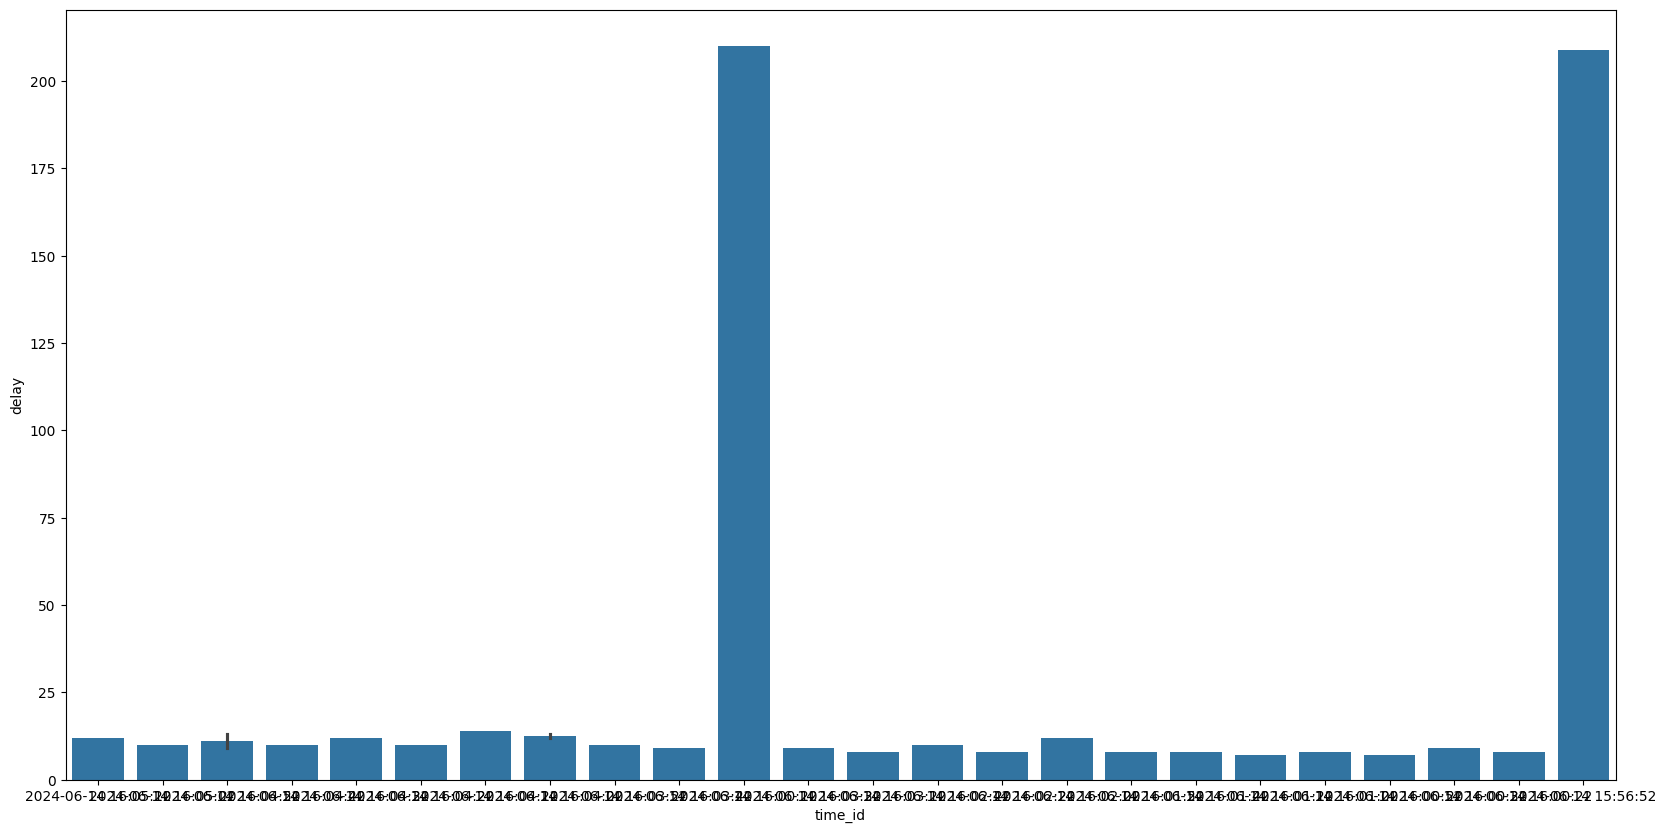

In [58]:
#trực quan hoá thời gian delay bằng biểu đồ cột không hiển thị cột time_id
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.barplot(x='time_id', y='delay', data=df)
plt.show()
